##Goal

Goal of this notebook is to classify real and fake news. 
To achive this goal we will:
- Analise a data and try to make features with high predictive power
- Make a few ML models and compare them and check best features
- Make a DL model based on BERT 
- Try to find way's to improve by analysing weakneses of model 

##What is fake news?


Fake news refers to false or misleading information which masquerades as legitimate news. Generally, fake news falls into two categories:

- Deliberately inaccurate stories – that is, the people publishing them know them to be false but publish them anyway. This might be to manipulate public opinion or to drive traffic to a specific website.
- Stories that contain elements of truth but are broadly inaccurate. This might be because the writer hasn’t checked all their facts or has exaggerated certain aspects to make a particular point.

**We can't differentiate precisely written fake news from real one without fact checking. We can focus on particular features of fake news, maybe they are written with less care about spelling, maybe fake news uses a lot of punctuation marks, it is possible that mode words are written in capital letters to stir up controversy. It's possible that certain words are used more often for fake news, maybe they are definitely shorter/longer. This is what we will try to find out during this analysis**

Importing libraries

In [ ]:
%%capture
%%bash
apt-get install libenchant1c2a -y
pip install pyenchant
pip install datasets
pip install shap
pip install xgboost
pip install catboost
pip install transformers
pip install transformers-interpret

In [ ]:
%%capture
import numpy as np
import pandas as pd
import cv2
import time
import os
import itertools
import random
import re
import calendar
import inspect
import copy
import string 

import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import pickle
import nltk
import enchant
from collections import Counter, defaultdict
from google.colab import drive
from subprocess import check_output


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    HalvingRandomSearchCV,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import GridSearchCV

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline,
)
from transformers_interpret import SequenceClassificationExplainer
from torch.utils.data import Dataset
import torch
import torch.nn.functional as F
from datasets import load_metric

import shap
import xgboost as xgb
import catboost as cb


random.seed(42)
np.random.seed(42)
%matplotlib inline
plt.style.use("ggplot")

import warnings

sns.set_style("darkgrid")
palete = sns.color_palette("magma")
sns.set_palette(palete)
sns.set(rc={"figure.figsize": (21 / 2, 9 / 2)})
warnings.simplefilter("always", category=UserWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)
pd.set_option("display.max_columns", None)

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

In [ ]:
class ColabManager:
    import inspect

    def __init__(self, folder_name):
        drive.mount("/content/drive", force_remount=True)
        global path
        path = f"drive/MyDrive/{folder_name}/"

        try:
            os.mkdir(f"{path}variables")
        except FileExistsError:
            print("ColabManager was already initiated for this script")
        print(f"ColabManager in path: {path}")

    def save_var(self, var):
        for fi in reversed(inspect.stack()):
            names = [
                var_name
                for var_name, var_val in fi.frame.f_locals.items()
                if var_val is var
            ]
            if len(names) > 0:
                name = names[0]
                break
        with open(f"{path}variables/{name}", "wb") as f:
            pickle.dump(var, f)

    def load_var(self, name):
        with open(f"{path}variables/{name}", "rb") as f:
            return pickle.load(f)

    def variables(self):
        return f'{[file for file in os.listdir(f"{path}variables") if "." not in file]}'

Mounting drive

In [ ]:
cm = ColabManager("Fake and real news dataset")

Mounted at /content/drive
ColabManager was already initiated for this script
ColabManager in path: drive/MyDrive/Fake and real news dataset/


##EDA and feature enginering

Reading fake news dataset

In [ ]:
fake = pd.read_csv(f"{path}/Fake.csv")
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake.shape

(23481, 4)

Reading real news dataset

In [ ]:
true = pd.read_csv(f"{path}/True.csv")
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
true.shape

(21417, 4)

One hot encoding real and fake news

In [ ]:
fake["label"] = 0
true["label"] = 1

In [ ]:
df = pd.concat([fake, true], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


Optimising memory usage

In [ ]:
df["subject"] = df["subject"].astype("category")
df["label"] = df["label"].astype("bool")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   title    44898 non-null  object  
 1   text     44898 non-null  object  
 2   subject  44898 non-null  category
 3   date     44898 non-null  object  
 4   label    44898 non-null  bool    
dtypes: bool(1), category(1), object(3)
memory usage: 1.1+ MB


As we can see we have very similar number of samples for each category

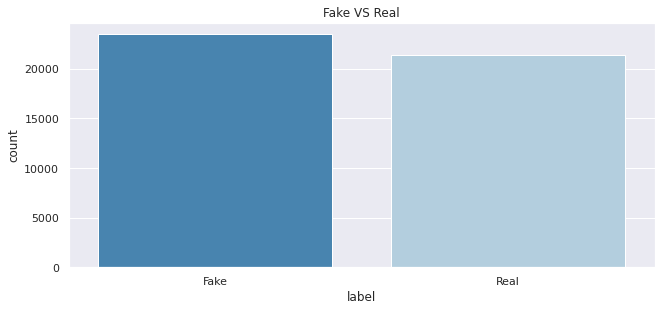

In [ ]:
chart = sns.countplot(x="label", data=df, palette="Blues_r")
chart.set_xticklabels(["Fake", "Real"])
plt.title(
    "Fake VS Real",
);

##Cleaning dataset

Looking for null values

In [ ]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

We don't have any missing values in dataset

Looking for duplicates 

In [ ]:
df[df.duplicated()]

,title,text,subject,date,label
4106,Islamic State claims responsibility for Aden c...,CAIRO (Reuters) - Militant group Islamic State...,worldnews,"November 29, 2017",1
5547,Turkey seeks life sentences for 60 ex-military...,ISTANBUL (Reuters) - Sixty people including a ...,worldnews,"December 21, 2017",1
5909,Highlights: The Trump presidency on March 31 a...,(Reuters) - Highlights of the day for U.S. Pre...,politicsNews,"March 31, 2017",1
6382,Britain preparing to transfer 400 million poun...,LONDON (Reuters) - Britain is preparing to tra...,worldnews,"November 16, 2017",1
6779,Israel ambassador asks to meet New Zealand pop...,WELLINGTON (Reuters) - Israel s ambassador to ...,worldnews,"December 27, 2017",1
...,...,...,...,...,...
44673,Kuwait says GCC to keep operating despite Qata...,DUBAI (Reuters) - Kuwait s deputy foreign mini...,worldnews,"December 27, 2017",1
44721,Syrian rebels say discussing evacuation from t...,BEIRUT (Reuters) - Syrian rebels in a pocket o...,worldnews,"December 27, 2017",1
44786,Russia may widen designation for media outlets...,MOSCOW (Reuters) - Russia may decide to design...,worldnews,"December 21, 2017",1
44849,Senate tax bill stalls on deficit-focused 'tri...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"November 30, 2017",1


As we can see we have 209 dupicates 206 in news dataset and 3 in fake.

In [ ]:
print("Duplicated all columns")
df[df.duplicated()].label.value_counts()

Duplicated all columns


1    206
0      3
Name: label, dtype: int64

Droping duplicates

In [ ]:
df = df.drop_duplicates(keep="first")

Looking for duplicated `text` column

In [ ]:
print("Duplicated text column")
df[df.duplicated(subset="text")].label.value_counts()

Duplicated text column


0    6023
1      20
Name: label, dtype: int64

Droping duplicates

In [ ]:
df = df.drop_duplicates(subset="text", keep="first")

###Date

Standardising date for visualization 

In [ ]:
def _day(x):
    try:
        value = re.search("\d{2}", x).group()
    except:
        value = df["day"] = np.nan
    return value


def _year(x):
    try:
        value = re.search("\d{4}", x).group()
    except:
        value = df["year"] = np.nan
    return value


df["month"] = df["date"].apply(lambda x: re.split("\s", x, 1)[0])
df["year"] = df["date"].apply(_year)
df["day"] = df["date"].apply(_day)
df = df.dropna()
df.head()

,title,text,subject,date,label,month,year,day
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0,February,2017,13
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1,April,2017,20
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1,September,2017,27
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0,May,2017,22
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1,June,2016,24


Looking for anomalies

In [ ]:
df.month.unique()

array(['February', 'April', 'September', 'May', 'June', 'Feb', 'Mar',
       'December', 'Dec', 'Oct', 'March', 'January', 'November',
       'October', 'Jun', 'Aug', 'Apr', 'August', 'Nov', 'Sep', 'July',
       'Jan', 'Jul',
       'https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg',
       'https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg'],
      dtype=object)

In [ ]:
bad_samples = df[
    (
        df["month"]
        == "https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg"
    )
    | (
        df["month"]
        == "https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg"
    )
]
df.drop(bad_samples.index, axis=0, inplace=True)

In [ ]:
month_dict = dict()
for index, months in enumerate(zip(calendar.month_abbr, calendar.month_name), 0):
    for month in months:
        month_dict[month] = index

df["month"] = df["month"].map(month_dict)
df["year"] = df["year"].apply(str)
df["month"] = df["month"].apply(str)
df["day"] = df["day"].apply(str)
df["new_date"] = df["year"] + "-" + df["month"] + "-" + df["day"]
df["new_date"] = pd.to_datetime(df["new_date"])
df.drop(columns=["date", "day", "month", "year"], inplace=True)
df["new_date"].describe().to_frame()
df.head()

,title,text,subject,label,new_date
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,0,2017-02-13
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,1,2017-04-20
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,1,2017-09-27
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,0,2017-05-22
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,1,2016-06-24


As we can see our data is skewed in terms of date. It could be soures of bias. We will drop this column. As we can see on chart bellow we only have fake news before january 2016 and the vast majority of real news in the final period. This can lead to a certain bias in the model, as it will highlight words related to the events of the period. Unfortunately, this is quite a large number of samples, so we will leave them as they are.

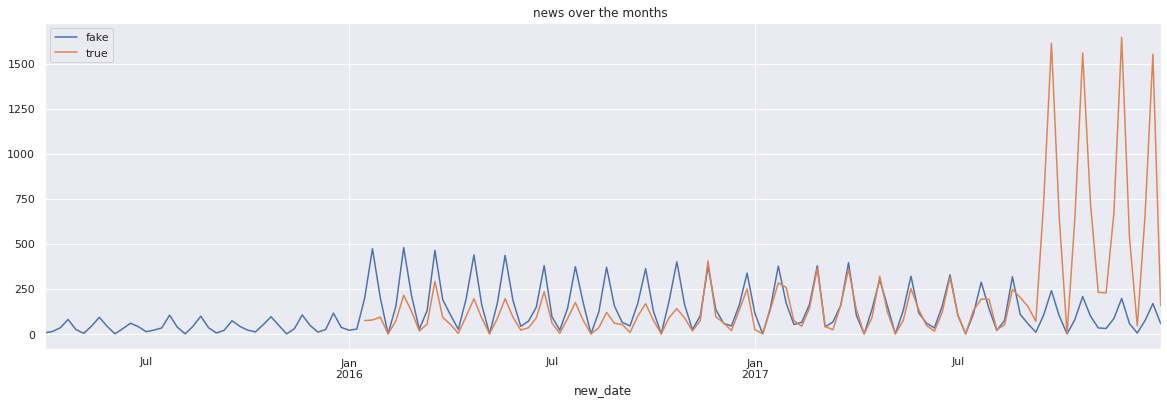

In [ ]:
plt.figure(figsize=(20, 6))
df[df["label"] == 0].groupby([pd.Grouper(key="new_date", freq="W")])[
    "label"
].count().plot(kind="line", label="fake")
df[df["label"] == 1].groupby([pd.Grouper(key="new_date", freq="W")])[
    "label"
].count().plot(kind="line", label="true")
plt.title("news over the months ")
plt.legend();

###Subject

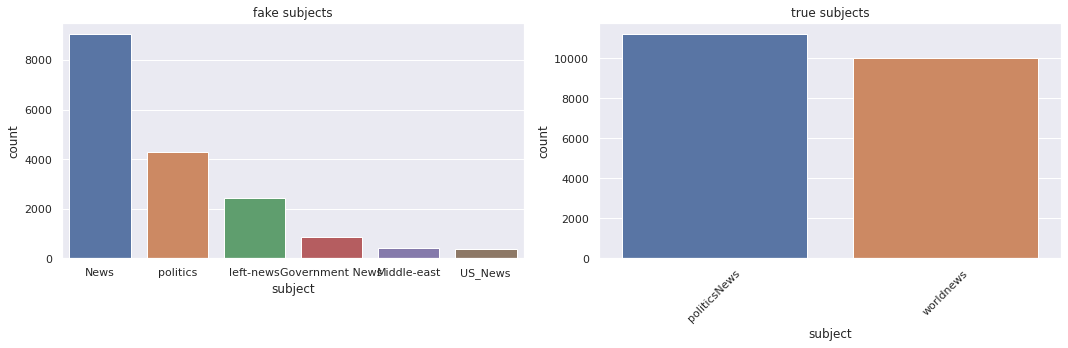

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
sns.countplot(
    x="subject",
    data=df[df["label"] == 0],
    order=df[df["label"] == 0]["subject"].value_counts().index,
    ax=ax[0],
).set(title="fake subjects")
plt.xticks(rotation=45)
sns.countplot(
    x="subject",
    data=df[df["label"] == 1],
    order=df[df["label"] == 1]["subject"].value_counts().index,
    ax=ax[1],
).set(title="true subjects")
plt.tight_layout();

As we can see column `subject` constists 8 categories, but unfortunately we can't use data from this column becouse we don't have overlaping categories in fake and real news. We will drop this column.

##Length of texts

Now let's take a look on length of text and titles.

As we can see lengths of titles are very different for both groups, but to our surprise fake titles are longer. 

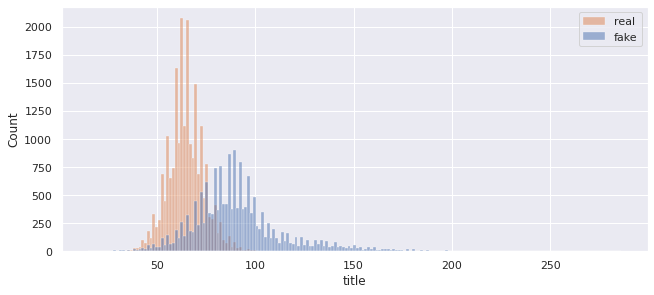

In [ ]:
sns.set(rc={"figure.figsize": (21 / 2, 9 / 2)})
sns.histplot(x=df.title.apply(len), hue=df.label)
plt.legend(["real", "fake"]);

Lengths of text are also quite different.

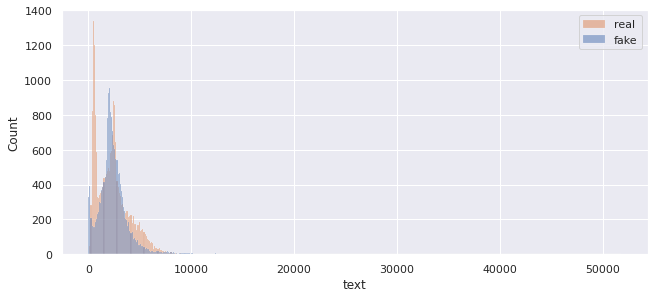

In [ ]:
sns.histplot(x=df.text.apply(len), hue=df.label)
plt.legend(["real", "fake"]);

###Text

Now let's look at accual text

In [ ]:
for i in range(10):
    print(f"FAKE NEWS: {i}")
    print(df[df.label == 0].iloc[i].get("text"))

FAKE NEWS: 0
21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame appearing in TV shows and films such as Ferris Bueller s Day Off) made some provocative statements on Judge Jeanine Pirro s show recently. While discussing the halt that was imposed on President Trump s Executive Order on travel. Stein referred to the judgement by the 9th Circuit Court in Washington state as a  Coup d tat against the executive branch and against the constitution.  Stein went on to call the Judges in Seattle  political puppets  and the judiciary  political pawns. Watch the interview below for the complete statements and note the stark contrast to the rhetoric of the leftist media and pundits who neglect to note that no court has ever blocked any Presidential orders in immigration in the past or discuss the legal efficacy of the halt or the actual text of the Executive Order.READ MORE TRUMP NEWS AT: 21st Century Wire Trump FilesSUPPORT OUR WORK BY S

In [ ]:
for i in range(10):
    print(f"REAL NEWS: {i}")
    print(df[df.label == 1].iloc[i].get("text"))

REAL NEWS: 0
WASHINGTON (Reuters) - U.S. President Donald Trump removed his chief strategist Steve Bannon from the National Security Council on Wednesday, reversing his controversial decision early this year to give a political adviser an unprecedented role in security discussions. Trump’s overhaul of the NSC, confirmed by a White House official, also elevated General Joseph Dunford, chairman of the Joint Chiefs of Staff and Dan Coats, the director of National Intelligence who heads all 17 U.S. intelligence agencies. The official said the change moves the NSC “back to its core function of what it’s supposed to do.” It also appears to mark a victory for national security adviser H.R. McMaster, who had told some national security experts he felt he was in a “battle to the death” with Bannon and others on the White House staff. Vice President Mike Pence said Bannon would continue to play an important role in policy and played down the shake-up as routine. “This is just a natural evolution

After deep look in dataset we can see similarities between examples in each group. 

Mearging `title` and `text` in to one column `txt`



In [ ]:
df["txt"] = df["title"] + " " + df["text"]

In [ ]:
def count_regex(df, regex_expression):
    expression = re.compile(regex_expression)
    count = 0
    list_of_expressions = []
    for text in df["txt"]:
        findings = re.findall(expression, text)
        count += len(findings)
        if findings:
            list_of_expressions.extend(findings)
    return count, Counter(list_of_expressions).most_common()


def count_regex_rows(df, regex_expression):
    expression = re.compile(regex_expression)
    count = 0
    for text in df["txt"]:
        count += int(len(re.findall(expression, text)) > 0)
    return count

##Twitter handle

First thing thats conspicuous in our fake news is presence of twitter handles in fake data. 

In [ ]:
count, list_of_handes = count_regex(df[df.label == 0], r"@([A-Za-z0-9_]+)")
count

23983

Examples of handles in dataset 

In [ ]:
list_of_handes[:10]

[('realDonaldTrump', 4047),
 ('21WIRE', 291),
 ('FoxNews', 246),
 ('POTUS', 227),
 ('seanhannity', 200),
 ('HillaryClinton', 197),
 ('CNN', 164),
 ('SarahPalinUSA', 126),
 ('nytimes', 116),
 ('IvankaTrump', 107)]

Procentage of fake samples with  handles:

In [ ]:
round(
    count_regex_rows(df[df.label == 0], r"@([A-Za-z0-9_]+)")
    / len(df[df.label == 0])
    * 100,
    2,
)

27.02

Number of fake samples with handles:

In [ ]:
len(df[df.label == 0])

17414

Procentage of real news samples with  handles:

In [ ]:
round(
    count_regex_rows(df[df.label == 1], r"@([A-Za-z0-9_]+)")
    / len(df[df.label == 1])
    * 100,
    2,
)

1.33

Number of rea news samples with handles:

In [ ]:
count, list_of_handes = count_regex(df[df.label == 1], r"@([A-Za-z0-9_]+)")
count

804

In [ ]:
# df["twiter_handle_count"] = df.txt.apply(lambda x:len(re.findall(r'@([A-Za-z0-9_]+)',x)))

Probably some part of news in fake dataset was scraped from twitter, which could be source of bias. If we would include feature `twiter_handle_count` we would  be bulding twitter post detector, not fake news detector.

##Reuters

Real news dataset also has some weird pattern. As we could see on examples almost all real news starts with:


"NAME_OF_CITY (Reuters)" pattern.

For example:
- WASHINGTON (Reuters),
- PARIS (Reuters),
- VIENTIANE (Reuters)

Let's investigate that further.

Number of `(Reuters)` pattern rows in fake news dataset

In [ ]:
count, _ = count_regex(df[df.label == 0], r"\(Reuters\)")
count

7

Percent of `(Reuters)` pattern rows in fake news dataset

In [ ]:
round(
    count_regex_rows(df[df.label == 0], "\(Reuters\)") / len(df[df.label == 0]) * 100, 2
)

0.04

Number of `(Reuters)` pattern rows in real news dataset

In [ ]:
count, _ = count_regex(df[df.label == 1], r"\(Reuters\)")
count

21025

Percent of `(Reuters)` pattern rows in real news dataset

In [ ]:
round(
    count_regex_rows(df[df.label == 1], r"\(Reuters\)") / len(df[df.label == 1]) * 100,
    2,
)

99.21

As we can see our dataset has some big flaws, fake and real news has been collected from very different sources and probably all models trained on this dataset will be focusing on differences between those sources and not between fake or real news. 

From just this finding we could make clasiffier which has astronomically high accuracy. 

In [ ]:
def match_reuters(txt):
    return int(bool(re.search("\(Reuters\)", txt)))

In [ ]:
y_true = df.label
y_pred = df.txt.apply(match_reuters)

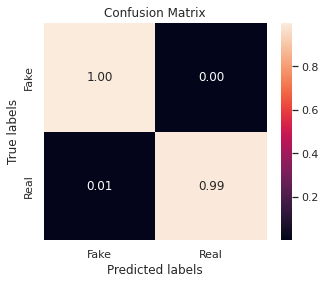

In [ ]:
sns.set(rc={"figure.figsize": (5, 4)})
conf = confusion_matrix(y_true, y_pred, normalize="true")
ax = sns.heatmap(
    conf,
    annot=True,
    fmt=".2f",
)
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["Fake", "Real"])
ax.yaxis.set_ticklabels(["Fake", "Real"]);

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     17414
           1       1.00      0.99      1.00     21191

    accuracy                           1.00     38605
   macro avg       1.00      1.00      1.00     38605
weighted avg       1.00      1.00      1.00     38605



As we can see very simple clasiffier can reach almost 100% accuracy. We should remove those prefixes from dataset.

Removing prefixes

In [ ]:
def remove_regex(sentence, regex):
    index = re.search(regex, sentence)
    if index:
        return sentence[index.span()[1] :]
    return sentence

In [ ]:
df.text = df.text.apply(lambda x: remove_regex(x, "\(Reuters\) \- "))
df.reset_index(drop=True);

In [ ]:
df["txt"] = df["title"] + " " + df["text"]

Let's dive deeper in our dataset and focuse on other factors of fake news. 

In [ ]:
def count_regex(df, regex_expression):
    regex_pattern = re.compile(regex_expression)
    count = 0
    for text in df["txt"]:
        count += len(re.findall(regex_pattern, text))
    return count

Lemmatizing test to capture general patterns

In [ ]:
tl=WordNetLemmatizer()
corpus=[]
for i in np.arange(len(df)):
    line=re.sub(r'[^a-zA-Z]',' ',df.iloc[i]['txt'])
    line=line.lower()
    line=line.split()
    line=[tl.lemmatize(word) for word in line if word not in stopwords.words('english')]
    line=" ".join(line)
    corpus.append(line)
cm.save_var(corpus)

In [ ]:
df.head()

,title,text,subject,label,new_date,txt,lemmatized_txt
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,0,2017-02-13,Ben Stein Calls Out 9th Circuit Court: Committ...,ben stein call th circuit court committed coup...
1,Trump drops Steve Bannon from National Securit...,U.S. President Donald Trump removed his chief ...,politicsNews,1,2017-04-20,Trump drops Steve Bannon from National Securit...,trump drop steve bannon national security coun...
2,Puerto Rico expects U.S. to lift Jones Act shi...,Puerto Rico Governor Ricardo Rossello said on ...,politicsNews,1,2017-09-27,Puerto Rico expects U.S. to lift Jones Act shi...,puerto rico expects u lift jones act shipping ...
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,0,2017-05-22,OOPS: Trump Just Accidentally Confirmed He Le...,oops trump accidentally confirmed leaked israe...
4,Donald Trump heads for Scotland to reopen a go...,Most U.S. presidential candidates go abroad to...,politicsNews,1,2016-06-24,Donald Trump heads for Scotland to reopen a go...,donald trump head scotland reopen golf resort ...


To find e.g. misspeled word, unusual abbreviation, strange terms etc. which there should be more in fake news. We will compare words from samples to English language dictionary.

In [ ]:
def check_if_exist(string):
    list_of_tokens = string.split(" ")
    d = enchant.DictWithPWL("en_US", "vocab.txt")
    count = 0
    for token in list_of_tokens:
        if not d.check(token) and not d.check(token.capitalize()):
            count += 1
    return count

In [ ]:
df["unusual_words"] = df.lemmatized_txt.apply(check_if_exist)

In [ ]:
df.head()

,title,text,subject,label,new_date,txt,lemmatized_txt,unusual_words
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,0,2017-02-13,Ben Stein Calls Out 9th Circuit Court: Committ...,ben stein call th circuit court committed coup...,7
1,Trump drops Steve Bannon from National Securit...,U.S. President Donald Trump removed his chief ...,politicsNews,1,2017-04-20,Trump drops Steve Bannon from National Securit...,trump drop steve bannon national security coun...,44
2,Puerto Rico expects U.S. to lift Jones Act shi...,Puerto Rico Governor Ricardo Rossello said on ...,politicsNews,1,2017-09-27,Puerto Rico expects U.S. to lift Jones Act shi...,puerto rico expects u lift jones act shipping ...,6
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,0,2017-05-22,OOPS: Trump Just Accidentally Confirmed He Le...,oops trump accidentally confirmed leaked israe...,8
4,Donald Trump heads for Scotland to reopen a go...,Most U.S. presidential candidates go abroad to...,politicsNews,1,2016-06-24,Donald Trump heads for Scotland to reopen a go...,donald trump head scotland reopen golf resort ...,9


Now for every sample we count `unusual_words_pct` - procentage of unusual words in sample.

In [ ]:
df["unusual_words_pct"] = (
    df.unusual_words / df.txt.apply(lambda x: len(x.split(" "))) * 100
)

In [ ]:
df.head()

,title,text,subject,label,new_date,txt,lemmatized_txt,unusual_words,unusual_words_pct
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,0,2017-02-13,Ben Stein Calls Out 9th Circuit Court: Committ...,ben stein call th circuit court committed coup...,7,3.684211
1,Trump drops Steve Bannon from National Securit...,U.S. President Donald Trump removed his chief ...,politicsNews,1,2017-04-20,Trump drops Steve Bannon from National Securit...,trump drop steve bannon national security coun...,44,5.648267
2,Puerto Rico expects U.S. to lift Jones Act shi...,Puerto Rico Governor Ricardo Rossello said on ...,politicsNews,1,2017-09-27,Puerto Rico expects U.S. to lift Jones Act shi...,puerto rico expects u lift jones act shipping ...,6,1.892744
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,0,2017-05-22,OOPS: Trump Just Accidentally Confirmed He Le...,oops trump accidentally confirmed leaked israe...,8,3.738318
4,Donald Trump heads for Scotland to reopen a go...,Most U.S. presidential candidates go abroad to...,politicsNews,1,2016-06-24,Donald Trump heads for Scotland to reopen a go...,donald trump head scotland reopen golf resort ...,9,1.675978


In [ ]:
def plot_diff(column_name: str) -> None:
    sns.set(rc={"figure.figsize": (21 / 2, 9 / 2)})
    sns.distplot(df[df["label"] == 0][column_name], color="red")
    sns.distplot(df[df["label"] == 1][column_name], color="blue")
    plt.title(f'Real vs Fake by {column_name.replace("_"," ")}', fontsize=15)
    plt.legend(labels=["Fake", "Real"])

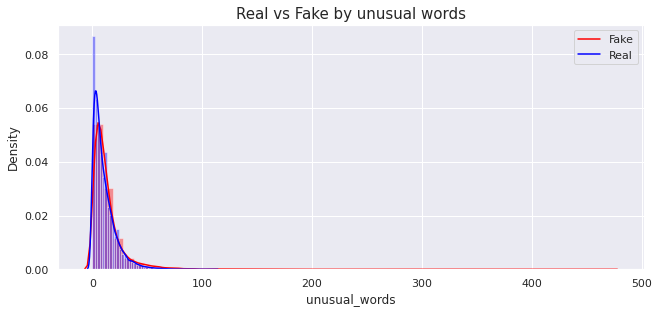

In [ ]:
plot_diff("unusual_words")

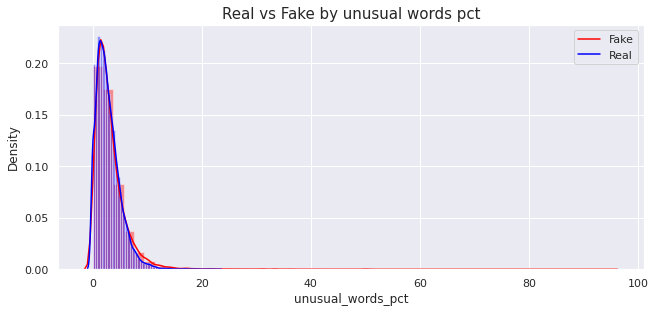

In [ ]:
plot_diff("unusual_words_pct")

As we can we have more unusula words for fake news samples.

Fake

In [ ]:
df[df.label == 0].unusual_words_pct.describe()

count    17414.000000
mean         3.259296
std          3.368808
min          0.000000
25%          1.366120
50%          2.500000
75%          4.166667
max         94.696970
Name: unusual_words_pct, dtype: float64

Real

In [ ]:
df[df.label == 1].unusual_words_pct.describe()

count    21191.000000
mean         2.847555
std          2.194086
min          0.000000
25%          1.253133
50%          2.409639
75%          3.956835
max         22.727273
Name: unusual_words_pct, dtype: float64

Now let's build more complex feature. Let's find most popular words for each group compared to other.

In [ ]:
def frequency_diff(row, reversed=False):
    all_fake_comments = " ".join(df[df.label == 0][row].tolist()).split(" ")
    all_real_comments = " ".join(df[df.label == 1][row].tolist()).split(" ")
    real_comments_freq = {
        word: count / len(all_real_comments) * 100
        for word, count in Counter(all_real_comments).most_common()
    }
    fake_comments_freq = {
        word: count / len(all_fake_comments) * 100
        for word, count in Counter(all_fake_comments).most_common()
    }
    all_words = set(real_comments_freq.keys())
    all_words.update(set(fake_comments_freq.keys()))
    dd_real_comments_freq = defaultdict(int, real_comments_freq)
    dd_fake_comments_freq = defaultdict(int, fake_comments_freq)
    all_words = set(real_comments_freq.keys())
    all_words.update(set(fake_comments_freq.keys()))

    def _helper(k, reversed):
        try:
            if reversed:
                return dd_real_comments_freq[k] / dd_fake_comments_freq[k]
            return dd_fake_comments_freq[k] / dd_real_comments_freq[k]
        except ZeroDivisionError:
            return 0

    word_diff = {k: _helper(k, reversed=reversed) for k in all_words}
    return sorted(word_diff.items(), key=lambda x: abs(x[1]), reverse=True)

Most popular words in fake news raw `txt` compared to real news.

In [ ]:
frequency_diff("txt")[:20]

[('more:', 1087.3464714869247),
 ('Him', 724.1792158961481),
 ('MEMBER', 387.9531513729365),
 ('screenshot', 374.4825558391539),
 ('Wire', 363.8856873525784),
 ('Image:', 363.16725559077673),
 ('HILLARY', 357.77901737726364),
 ('WATCH', 314.6731116691596),
 ('Racist', 309.28487345564656),
 ('racists', 299.5860446713232),
 ('(@realDonaldTrump)', 269.95073449700163),
 ('Files', 260.79072953402954),
 ('THIS', 258.63543424862434),
 ('Goes', 250.01425310700353),
 ('WOW!', 224.1507096821411),
 ('screengrab', 206.36952357754816),
 ('/', 205.2918759348456),
 ('image:', 202.59775682808908),
 ('OBAMA', 201.52010918538645),
 ('Supporter', 186.43304218755003)]

Most popular words in real news raw `txt` compared to fake news.

In [ ]:
frequency_diff("txt", reversed=True)[:20]

[('Rohingya', 1854.0382967750697),
 ('Myanmar', 1169.2133403086025),
 ('president’s', 775.763771823803),
 ('“a', 762.7725124870407),
 ('Hariri', 755.3489357231766),
 ('China’s', 581.8228288678522),
 ('SPD', 476.0368599827882),
 ('“But', 364.68320852482606),
 ('Catalan', 350.4546863940864),
 ('“As', 321.0696950371242),
 ('Juncker', 292.3033350771506),
 ('there’s', 290.4474408861846),
 ('al-Zor', 259.82518673524504),
 ('“the', 250.5457157804148),
 ('Kenyatta', 247.76187449396576),
 ('Xinhua', 238.48240353913562),
 ('Rico’s', 215.28372615206013),
 ('Abadi', 205.07630810174697),
 ('-', 198.50170421247367),
 ('Rauner', 192.08504876498472)]

Most popular words in fake news raw `lemmatized_txt` compared to real news.

In [ ]:
frequency_diff("lemmatized_txt")[:20]

[('getty', 4762.769249974801),
 ('http', 4077.934135490749),
 ('pic', 1934.0357490835327),
 ('amp', 618.078078114178),
 ('ck', 493.77187245992985),
 ('screenshot', 384.8121119481816),
 ('screengrab', 324.57731476387),
 ('bundy', 283.14191287912064),
 ('hilarious', 237.86989970874635),
 ('lahren', 210.62995958080924),
 ('ammon', 208.32799280943428),
 ('asshole', 201.42209249530939),
 ('tx', 181.8553749386222),
 ('streep', 172.64750785312233),
 ('skidmore', 169.19455769605986),
 ('shit', 159.98669061056003),
 ('subscribe', 154.80726537496633),
 ('clueless', 153.08079029643514),
 ('interestingly', 153.08079029643514),
 ('aka', 150.77882352506018)]

Most popular words in real news raw `lemmatized_txt` compared to fake news.

In [ ]:
frequency_diff("lemmatized_txt", reversed=True)[:20]

[('rohingya', 1929.6542657506711),
 ('myanmar', 669.6447660186087),
 ('hariri', 480.8931274619524),
 ('fdp', 463.9510931611249),
 ('kirkuk', 457.86933725826367),
 ('juncker', 335.3653969292026),
 ('gulen', 308.4319065022459),
 ('kenyatta', 277.1543047161027),
 ('xinhua', 233.71319112423708),
 ('spd', 218.94321250300277),
 ('catalan', 159.49094561584948),
 ('pinera', 154.6503643870416),
 ('ite', 152.0438975715297),
 ('rauner', 138.14274122213268),
 ('berlusconi', 132.9298075911088),
 ('unionist', 132.06098531927148),
 ('lindner', 124.24158487273567),
 ('mugabe', 112.83829255487097),
 ('graft', 111.42645636313533),
 ('detente', 110.34042852333869)]

Most words in this list make sense, but very high percentage inform as that dataset is very biased.

###Capital letters

How about capital letters ratio? In fake dataset should be more capital letters - to focus attention of reader and to underline controversy.  

In [ ]:
def count_capital(string):
    return len(re.findall("[A-Z]+[^a-z1-9]", string))

In [ ]:
df["capital_ratio_title"] = (
    df.title.apply(count_capital) / df.title.apply(lambda x: len(x.split(" "))) * 100
)

In [ ]:
df["capital_ratio_text"] = (
    df.text.apply(count_capital) / df.text.apply(lambda x: len(x.split(" "))) * 100
)

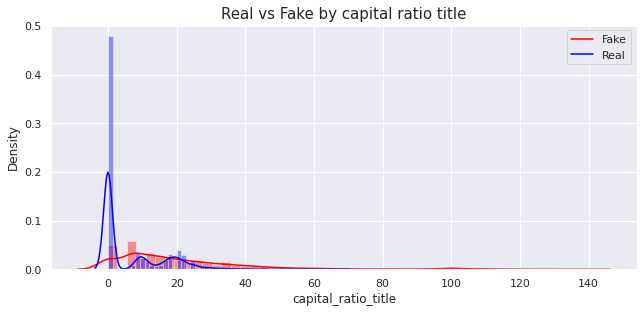

In [ ]:
plot_diff("capital_ratio_title")

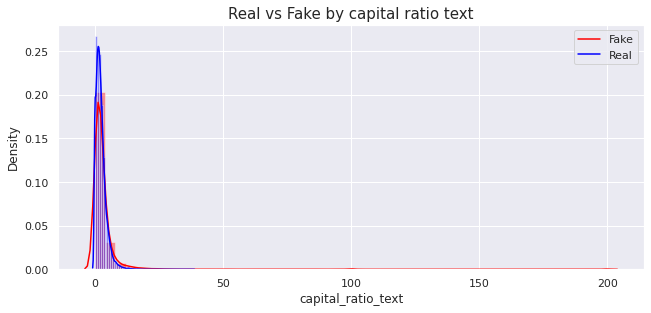

In [ ]:
plot_diff("capital_ratio_text")

Especially for titles we have very high differences in capital letters. 

###Average length of word 

In [ ]:
df["text_len"] = df.text.apply(lambda x: len(x.split(" ")))
df["title_len"] = df.title.apply(lambda x: len(x.split(" ")))

In [ ]:
df["avg_word_len"] = df.text.apply(lambda x: len(x) / len(x.split(" ")))

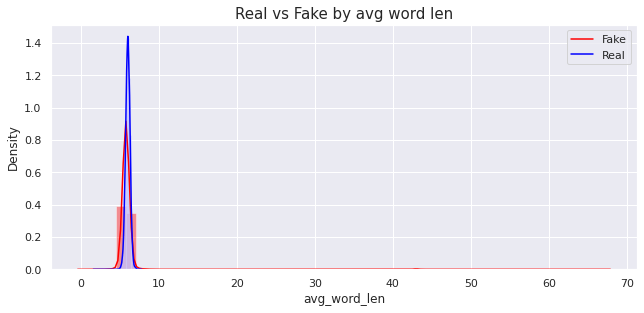

In [ ]:
plot_diff("avg_word_len")

As we can see average length of word is higer for real dataset.

##Predictions

We will start with prediction using metadata alone, without using specific words. 
We will use:
-  BernoulliNB,
-  GaussianNB,
-  MLPClassifier,
-  XGBClassifier,
-  RandomForestClassifier,
-  CatBoostClassifier

In [ ]:
def algorithm(model):
    model.fit(x_train, y_train)

    train_model_score = model.score(x_train, y_train)
    y_pred_train = model.predict(x_train)

    test_model_score = model.score(x_test, y_test)
    y_pred_test = model.predict(x_test)

    print("Train score :", round(train_model_score, 3))
    print("Test score :", round(test_model_score, 3))

    df_model = pd.DataFrame(
        classification_report(y_pred_test, y_test, digits=3, output_dict=True)
    ).T
    df_model["support"] = df_model.support.apply(int)
    df_model.style.background_gradient(
        cmap="viridis", subset=pd.IndexSlice["0":"9", :"f1-score"]
    )
    display(df_model)

    conf_mat = confusion_matrix(y_test, y_pred_test, normalize="true")
    ax = sns.heatmap(
        conf_mat,
        annot=True,
        fmt=".2f",
    )
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(["Fake", "Real"])
    ax.yaxis.set_ticklabels(["Fake", "Real"])
    plt.show()
    return round(test_model_score, 3)

Spliting data

In [ ]:
df_ml = df.drop(
    columns=["title", "text", "subject", "new_date", "txt", "lemmatized_txt"]
)
train, test = train_test_split(df_ml, test_size=0.2, shuffle=True, seed=42)
print("Samples in Training:", train.shape[0])
print("Samples in Test:", test.shape[0])

Samples in Training: 30884
Samples in Test: 7721


In [ ]:
df_ml

,label,unusual_words,unusual_words_pct,capital_ratio_title,capital_ratio_text,text_len,title_len,avg_word_len
0,0,7,3.684211,0.000000,9.090909,176,14,5.840909
1,1,44,5.648267,0.000000,3.631647,771,8,6.221790
2,1,6,1.892744,20.000000,2.605863,307,10,5.980456
3,0,8,3.738318,15.384615,3.980100,201,13,6.189055
4,1,9,1.675978,0.000000,2.277040,527,10,5.895636
...,...,...,...,...,...,...,...,...
44890,1,10,3.472222,0.000000,1.444043,277,11,6.169675
44892,0,10,3.676471,13.333333,1.945525,257,15,5.556420
44894,1,12,1.623816,9.090909,1.785714,728,11,5.938187
44895,1,2,2.272727,0.000000,1.265823,79,9,5.253165


In [ ]:
x_train, y_train = train.loc[:, train.columns != "label"], train["label"]
x_test, y_test = test.loc[:, test.columns != "label"], test["label"]

###GaussianNB

Train score : 0.792
Test score : 0.796


,precision,recall,f1-score,support
0,0.587980,0.932203,0.721120,2183
1,0.965258,0.742506,0.839355,5538
accuracy,0.796140,0.796140,0.796140,0
macro avg,0.776619,0.837355,0.780237,7721
weighted avg,0.858588,0.796140,0.805926,7721


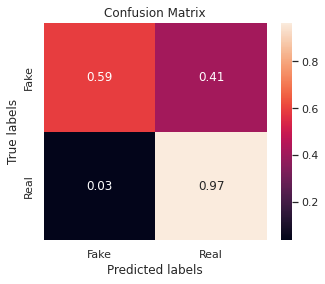

In [ ]:
sns.set(rc={"figure.figsize": (5, 4)})
gnv = GaussianNB()
score_gvn = algorithm(gnv);

###BernoulliNB

Train score : 0.734
Test score : 0.743


,precision,recall,f1-score,support
0,0.835308,0.670921,0.744144,4309
1,0.667136,0.832943,0.740876,3412
accuracy,0.742520,0.742520,0.742520,0
macro avg,0.751222,0.751932,0.742510,7721
weighted avg,0.760991,0.742520,0.742700,7721


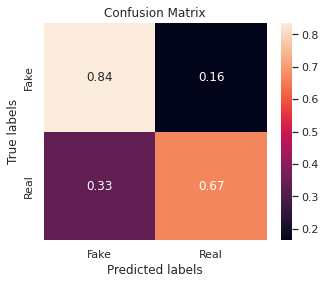

In [ ]:
bnv = BernoulliNB()
score_bnv = algorithm(bnv);

###MLPClassifier

Train score : 0.889
Test score : 0.891


,precision,recall,f1-score,support
0,0.931234,0.843055,0.884953,3823
1,0.859155,0.938943,0.897279,3898
accuracy,0.891465,0.891465,0.891465,0
macro avg,0.895194,0.890999,0.891116,7721
weighted avg,0.894844,0.891465,0.891176,7721


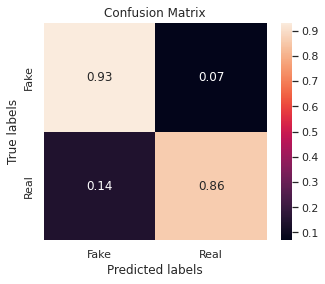

In [ ]:
mlp = MLPClassifier()
score_mlp = algorithm(mlp);

###RandomForestClassifier

Train score : 1.0
Test score : 0.92


,precision,recall,f1-score,support
0,0.895117,0.923673,0.909171,3354
1,0.939906,0.916877,0.928249,4367
accuracy,0.919829,0.919829,0.919829,0
macro avg,0.917512,0.920275,0.918710,7721
weighted avg,0.920450,0.919829,0.919961,7721


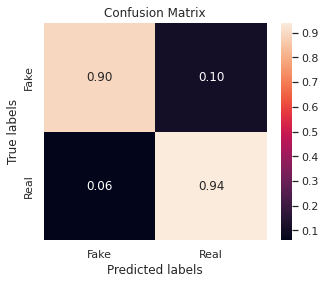

In [ ]:
rf = RandomForestClassifier()
score_rf = algorithm(rf);

####XGBClassifier

Train score : 0.952
Test score : 0.918


,precision,recall,f1-score,support
0,0.889627,0.923792,0.906388,3333
1,0.940376,0.912944,0.926457,4388
accuracy,0.917627,0.917627,0.917627,0
macro avg,0.915001,0.918368,0.916422,7721
weighted avg,0.918469,0.917627,0.917794,7721


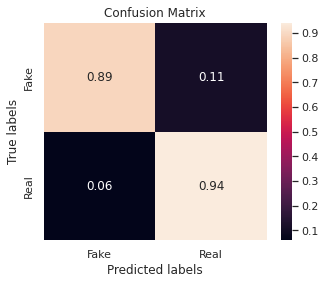

In [ ]:
sns.set(rc={"figure.figsize": (5, 4)})
_xbg = xgb.XGBClassifier()
score_xgb = algorithm(_xbg);

###CatBoostClassifier

Train score : 0.94
Test score : 0.919


,precision,recall,f1-score,support
0,0.892517,0.925127,0.908529,3339
1,0.941315,0.915107,0.928026,4382
accuracy,0.919440,0.919440,0.919440,0
macro avg,0.916916,0.920117,0.918278,7721
weighted avg,0.920212,0.919440,0.919595,7721


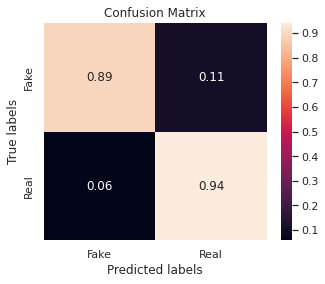

In [ ]:
sns.set(rc={"figure.figsize": (5, 4)})
_cb = cb.CatBoostClassifier(iterations=1000, verbose=100)
score_cb = algorithm(_cb);

###Comparing f1 scores

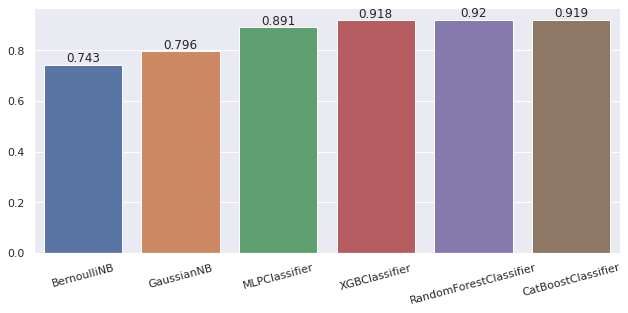

In [ ]:
sns.set(rc={"figure.figsize": (21 / 2, 9 / 2)})
_names = [
    "BernoulliNB",
    "GaussianNB",
    "MLPClassifier",
    "XGBClassifier",
    "RandomForestClassifier",
    "CatBoostClassifier",
]
_scores = [score_bnv, score_gvn, score_mlp, score_xgb, score_rf, score_cb]

ax = sns.barplot(x=_names, y=_scores)
plt.xticks(rotation=15)
for i in ax.containers:
    ax.bar_label(
        i,
    );

As we can see `XGBClassifier`, `RandomForestClassifier` and `CatBoostClassifier` were best and pretty much the same in terms of accuracy and f1_score. F1_score = 0.92 is very high score for just few metadata features without any specyfic word feature. 

Now let's try to optimize hyperparamiters 

In [ ]:
n_estimators = [32, 64, 100, 128, 200, 256, 512]
max_features = [7, 9, 12, 15]
bootstrap = [True, False]

param_dist = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "bootstrap": bootstrap,
}

rfc = RandomForestClassifier(random_state=42)
cv_rfc = HalvingRandomSearchCV(rfc, param_dist)
cv_rfc.fit(x_train, y_train)
for key in param_dist.keys():
    print(f"{key}:{cv_rfc.best_estimator_.__dict__.get(key)}")

n_estimators:512
max_features:7
bootstrap:True


Train score : 1.0
Test score : 0.919


,precision,recall,f1-score,support
0,0.893383,0.923261,0.908076,3349
1,0.939671,0.915599,0.927479,4372
accuracy,0.918922,0.918922,0.918922,0
macro avg,0.916527,0.919430,0.917778,7721
weighted avg,0.919594,0.918922,0.919063,7721


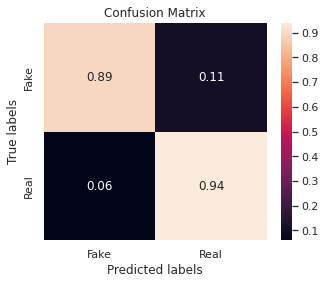

0.919

In [ ]:
sns.set(rc={"figure.figsize": (5, 4)})
rf = RandomForestClassifier(n_estimators=512, max_features=7, bootstrap=True)
algorithm(rf);

In [ ]:
model = xgb.XGBClassifier()
param_dist = {
    "max_depth": [1, 2, 3, 5, 10, 30, 50],
    "min_child_weight": [1, 3, 6],
    "n_estimators": [128, 200, 256, 512],
    "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.16],
}
cv_xgb = HalvingRandomSearchCV(model, param_distributions=param_dist, cv=5, n_jobs=-1)
cv_xgb.fit(x_train, y_train)
for key in param_dist.keys():
    print(f"{key}:{cv_xgb.best_estimator_.__dict__.get(key)}")

max_depth:5
min_child_weight:1
n_estimators:200
learning_rate:0.05


Train score : 0.948
Test score : 0.919


,precision,recall,f1-score,support
0,0.890494,0.925248,0.907538,3331
1,0.941549,0.913667,0.927399,4390
accuracy,0.918663,0.918663,0.918663,0
macro avg,0.916022,0.919458,0.917469,7721
weighted avg,0.919523,0.918663,0.918831,7721


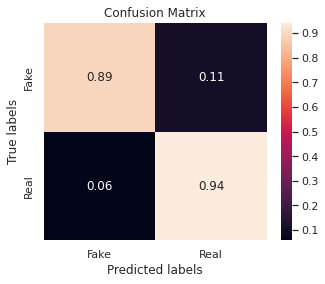

In [ ]:
sns.set(rc={"figure.figsize": (5, 4)})
_xbg = xgb.XGBClassifier(min_child_weight=1, n_estimators=256, learning_rate=0.1)
xgb_score_2 = algorithm(_xbg);

Train score : 0.94
Test score : 0.919


,precision,recall,f1-score,support
0,0.892517,0.925127,0.908529,3339
1,0.941315,0.915107,0.928026,4382
accuracy,0.919440,0.919440,0.919440,0
macro avg,0.916916,0.920117,0.918278,7721
weighted avg,0.920212,0.919440,0.919595,7721


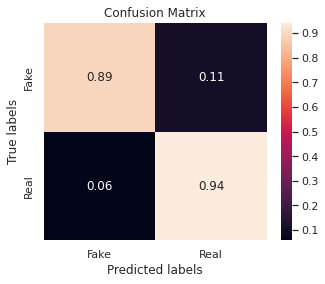

0.919

In [ ]:
sns.set(rc={"figure.figsize": (5, 4)})
_cb = cb.CatBoostClassifier(iterations=1000, verbose=100)
algorithm(_cb);

Results after optimisation are basically the same.

##Feature importance

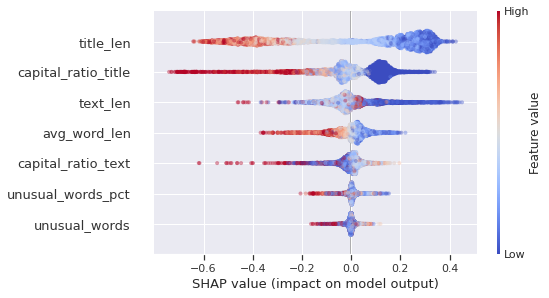

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values[1], x_test, cmap="coolwarm", alpha=0.4)
cm.save_var(explainer)

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame(
        {"Feature": df.columns, "Importance": m.feature_importances_}
    ).sort_values("Importance", ascending=False)


fi = rf_feat_importance(rf, x_train)
fi[:10].style.background_gradient(cmap="coolwarm")

,Feature,Importance
5,title_len,0.385825
2,capital_ratio_title,0.208311
6,avg_word_len,0.118379
4,text_len,0.102518
3,capital_ratio_text,0.079112
1,unusual_words_pct,0.061317
0,unusual_words,0.044538


###Adding features based on words

Adding most frequent word count as features we will use 100 most frequent words for each category. 

In [ ]:
txt_words = frequency_diff("txt")[:100]
txt_words.extend(frequency_diff("txt", reversed=True)[:100])

lemmatized_txt_words = frequency_diff("lemmatized_txt")[:100]
lemmatized_txt_words.extend(frequency_diff("lemmatized_txt", reversed=True)[:100])

In [ ]:
df_2 = copy.deepcopy(df)
for word, _ in lemmatized_txt_words:
    word = "".join(
        [
            char if char not in "[|\^&+\-%*/=!>]()?" else r"\{}".format(char)
            for char in word
        ]
    )
    df_2[f"{word}_lemmatized_txt_words_count"] = df_2.lemmatized_txt.apply(
        lambda x: len(re.findall(r"{}".format(word), x))
    )

In [ ]:
for word, _ in txt_words:
    word = "".join(
        [
            char if char not in "[|\^&+\-%*/=!>]()?" else r"\{}".format(char)
            for char in word
        ]
    )
    df_2[f"{word}_txt_count"] = df_2.txt.apply(
        lambda x: len(re.findall(r"{}".format(word), x))
    )

Spliting data

In [ ]:
df_ml_2 = df_2.drop(
    columns=["title", "text", "subject", "new_date", "txt", "lemmatized_txt"]
)
train, test = train_test_split(df_ml_2, test_size=0.2, shuffle=True, seed = 42)
print("Samples in Training:", train.shape[0])
print("Samples in Test:", test.shape[0])

Samples in Training: 30884
Samples in Test: 7721


In [ ]:
df_ml_2

,label,unusual_words,unusual_words_pct,capital_ratio_title,capital_ratio_text,text_len,title_len,avg_word_len,getty_lemmatized_txt_words_count,http_lemmatized_txt_words_count,pic_lemmatized_txt_words_count,amp_lemmatized_txt_words_count,ck_lemmatized_txt_words_count,screenshot_lemmatized_txt_words_count,screengrab_lemmatized_txt_words_count,bundy_lemmatized_txt_words_count,hilarious_lemmatized_txt_words_count,lahren_lemmatized_txt_words_count,ammon_lemmatized_txt_words_count,asshole_lemmatized_txt_words_count,tx_lemmatized_txt_words_count,streep_lemmatized_txt_words_count,skidmore_lemmatized_txt_words_count,shit_lemmatized_txt_words_count,subscribe_lemmatized_txt_words_count,clueless_lemmatized_txt_words_count,interestingly_lemmatized_txt_words_count,aka_lemmatized_txt_words_count,karma_lemmatized_txt_words_count,unreal_lemmatized_txt_words_count,bolling_lemmatized_txt_words_count,jeanine_lemmatized_txt_words_count,ivankatrump_lemmatized_txt_words_count,freak_lemmatized_txt_words_count,pissed_lemmatized_txt_words_count,evangelist_lemmatized_txt_words_count,creepy_lemmatized_txt_words_count,dickerson_lemmatized_txt_words_count,whoa_lemmatized_txt_words_count,wannabe_lemmatized_txt_words_count,whine_lemmatized_txt_words_count,lovable_lemmatized_txt_words_count,antifa_lemmatized_txt_words_count,baio_lemmatized_txt_words_count,takei_lemmatized_txt_words_count,damned_lemmatized_txt_words_count,luckily_lemmatized_txt_words_count,meryl_lemmatized_txt_words_count,lol_lemmatized_txt_words_count,tomi_lemmatized_txt_words_count,spew_lemmatized_txt_words_count,flashback_lemmatized_txt_words_count,classy_lemmatized_txt_words_count,conveniently_lemmatized_txt_words_count,thankfully_lemmatized_txt_words_count,idiocy_lemmatized_txt_words_count,featured_lemmatized_txt_words_count,ouch_lemmatized_txt_words_count,platt_lemmatized_txt_words_count,oswalt_lemmatized_txt_words_count,speakerryan_lemmatized_txt_words_count,humiliates_lemmatized_txt_words_count,busted_lemmatized_txt_words_count,begs_lemmatized_txt_words_count,gall_lemmatized_txt_words_count,tapper_lemmatized_txt_words_count,wt_lemmatized_txt_words_count,degeneres_lemmatized_txt_words_count,wilmore_lemmatized_txt_words_count,boiler_lemmatized_txt_words_count,ridiculously_lemmatized_txt_words_count,kalb_lemmatized_txt_words_count,maher_lemmatized_txt_words_count,pervert_lemmatized_txt_words_count,seanhannity_lemmatized_txt_words_count,sh_lemmatized_txt_words_count,yr_lemmatized_txt_words_count,pierson_lemmatized_txt_words_count,hannity_lemmatized_txt_words_count,lunatic_lemmatized_txt_words_count,predictably_lemmatized_txt_words_count,whiny_lemmatized_txt_words_count,snl_lemmatized_txt_words_count,ave_lemmatized_txt_words_count,acorn_lemmatized_txt_words_count,cspan_lemmatized_txt_words_count,moronic_lemmatized_txt_words_count,feminism_lemmatized_txt_words_count,gaga_lemmatized_txt_words_count,lemon_lemmatized_txt_words_count,varney_lemmatized_txt_words_count,cliven_lemmatized_txt_words_count,fucking_lemmatized_txt_words_count,roommate_lemmatized_txt_words_count,indoctrination_lemmatized_txt_words_count,kudos_lemmatized_txt_words_count,msm_lemmatized_txt_words_count,infowars_lemmatized_txt_words_count,pst_lemmatized_txt_words_count,shady_lemmatized_txt_words_count,ep_lemmatized_txt_words_count,meyers_lemmatized_txt_words_count,dinesh_lemmatized_txt_words_count,oddly_lemmatized_txt_words_count,trolling_lemmatized_txt_words_count,nypd_lemmatized_txt_words_count,paladino_lemmatized_txt_words_count,hating_lemmatized_txt_words_count,rohingya_lemmatized_txt_words_count,myanmar_lemmatized_txt_words_count,hariri_lemmatized_txt_words_count,fdp_lemmatized_txt_words_count,kirkuk_lemmatized_txt_words_count,juncker_lemmatized_txt_words_count,gulen_lemmatized_txt_words_count,kenyatta_lemmatized_txt_words_count,xinhua_lemmatized_txt_words_count,spd_lemmatized_txt_words_count,catalan_lemmatized_txt_words_count,pinera_lemmatized_txt_words_count,ite_lemmatized_txt_words_count,rauner_lemmatized_txt_words_c

In [ ]:
x_train, y_train = train.loc[:, train.columns != "label"], train["label"]
x_test, y_test = test.loc[:, test.columns != "label"], test["label"]

###RandomForestClassifier

Train score : 1.0
Test score : 0.985


,precision,recall,f1-score,support
0,0.981083,0.985887,0.983479,3472
1,0.988422,0.984467,0.986440,4249
accuracy,0.985106,0.985106,0.985106,0
macro avg,0.984752,0.985177,0.984960,7721
weighted avg,0.985122,0.985106,0.985109,7721


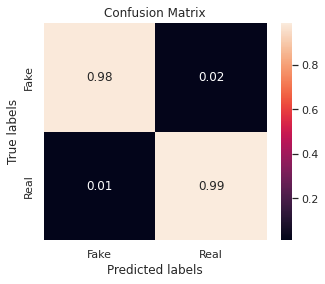

In [ ]:
_frc = RandomForestClassifier()
rf_score_3 = algorithm(_frc)

##CatBoostClassifier

Train score : 0.993
Test score : 0.986


,precision,recall,f1-score,support
0,0.979149,0.989754,0.984423,3416
1,0.991799,0.983275,0.987519,4305
accuracy,0.986142,0.986142,0.986142,0
macro avg,0.985474,0.986515,0.985971,7721
weighted avg,0.986202,0.986142,0.986149,7721


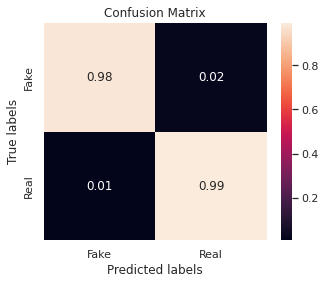

In [ ]:
_cb = cb.CatBoostClassifier(iterations=5000, verbose=500)
cb_score_3 = algorithm(_cb)

As we can see both algorithms has insanely high f1 scores it could means that our sets are very bised.  

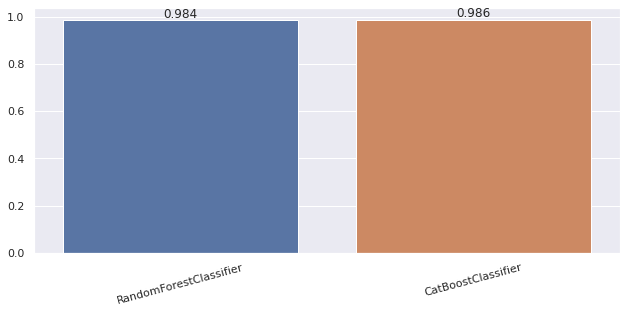

In [ ]:
sns.set(rc={"figure.figsize": (21 / 2, 9 / 2)})
_names = ["RandomForestClassifier", "CatBoostClassifier"]
_scores = [rf_score_3, cb_score_3]

ax = sns.barplot(x=_names, y=_scores)
plt.xticks(rotation=15)
for i in ax.containers:
    ax.bar_label(
        i,
    );

###Feature importance

In [ ]:
fi = rf_feat_importance(_frc, x_train)
fi[:10].style.background_gradient(cmap="coolwarm")

,Feature,Importance
5,title_len,0.177130
2,capital_ratio_title,0.134866
55,featured_lemmatized_txt_words_count,0.122299
223,\/_txt_count,0.048693
6,avg_word_len,0.045110
296,Image_txt_count,0.027126
239,Images_txt_count,0.022356
4,text_len,0.022196
7,getty_lemmatized_txt_words_count,0.021514
207,more:_txt_count,0.020443


###Deep Learning

For deeplearning part we will be using `distilbert-base-uncased-finetuned-sst-2-english` with full huggingface toolset.

In [ ]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Spliting data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df["txt"].tolist(), df["label"].tolist(), test_size=0.20, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42
)

In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

Dataset class

In [ ]:
class FakeRealDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = FakeRealDataset(train_encodings, y_train)
test_dataset = FakeRealDataset(test_encodings, y_test)
val_dataset = FakeRealDataset(val_encodings, y_val)

Adding metrics

In [ ]:
acc_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = acc_metric.compute(predictions=predictions, references=labels)["accuracy"]
    precision = precision_metric.compute(predictions=predictions, references=labels)[
        "precision"
    ]
    recall = recall_metric.compute(predictions=predictions, references=labels)["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels)["f1"]
    return {"acc": acc, "precision": precision, "recall": recall, "f1 score": f1}

Model will be training for only one epoch with 16 batch size and small learning rate = 5e-5.

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps=100,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

###Training

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Acc,Precision,Recall,F1 score
100,1.094800,0.250850,0.900291,0.859969,0.976937,0.914729
200,0.130500,0.071946,0.979605,0.989771,0.972797,0.981211
300,0.088400,0.033569,0.988993,0.994627,0.985216,0.989899
400,0.045300,0.058077,0.986080,0.998789,0.975754,0.987137
500,0.033700,0.034737,0.993525,0.990029,0.998226,0.994111
600,0.052200,0.019418,0.995792,0.999405,0.992904,0.996144
700,0.016900,0.030086,0.992230,0.986006,1.000000,0.992954
800,0.016600,0.007947,0.998058,0.998816,0.997635,0.998225
900,0.035000,0.017789,0.994497,0.999403,0.990538,0.994951
1000,0.005700,0.011127,0.998058,0.996464,1.000000,0.998229


TrainOutput(global_step=1738, training_loss=0.09327078815571047, metrics={'train_runtime': 535.1494, 'train_samples_per_second': 51.939, 'train_steps_per_second': 3.248, 'total_flos': 3681931345643520.0, 'train_loss': 0.09327078815571047, 'epoch': 1.0})

In [ ]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.0029211719520390034,
 'eval_acc': 0.9992228985882657,
 'eval_precision': 0.9992967651195499,
 'eval_recall': 0.9992967651195499,
 'eval_f1 score': 0.9992967651195499,
 'eval_runtime': 29.5949,
 'eval_samples_per_second': 260.89,
 'eval_steps_per_second': 16.32,
 'epoch': 1.0}

As we can see model has nearly 100% accuracy with only few samples misslabeled - we could be almost certainly sure that our dataset is hugely biased.  

###Explanation

In [ ]:
cls_explainer = SequenceClassificationExplainer(model, tokenizer)
word_attributions = cls_explainer(df.txt[1])

In [ ]:
cls_explainer.visualize("distilbert_viz.html")

In [ ]:
word_attributions = cls_explainer(df.txt[2])

In [ ]:
cls_explainer.visualize("distilbert_viz.html")

As shown model chosses correct words, but it also attaches importance to punctuation marks. Which, on the one hand, can significantly affect the evaluation, but on the other hand, sme punctuation marks can also indicate that the news is fake.
Let's train a second model without punctuation marks and compare the results.

###Model without punctuation

In [ ]:
special_characters = (
    string.printable[62:-6] + "’" + "‘" + "”" + "“" + "’" + "“" + "\xa0" + "\xa0"
)


def replace_special(_str):
    for char in special_characters:
        _str = _str.replace(char, " ")
    return _str


special_characters

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~’‘”“’“\xa0\xa0'

In [ ]:
df["txt_without_special"] = df["txt"].apply(replace_special)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df["txt_without_special"].tolist(),
    df["label"].tolist(),
    test_size=0.20,
    random_state=42,
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42
)
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)
train_dataset = FakeRealDataset(train_encodings, y_train)
test_dataset = FakeRealDataset(test_encodings, y_test)
val_dataset = FakeRealDataset(val_encodings, y_val)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Acc,Precision,Recall,F1 score
100,0.101200,0.052820,0.988022,0.996399,0.981668,0.988978
200,0.050600,0.019926,0.995792,0.997038,0.995269,0.996153
300,0.048900,0.022784,0.994820,0.997623,0.992904,0.995258
400,0.037700,0.053357,0.989641,0.999398,0.981668,0.990453
500,0.032400,0.045107,0.991259,0.998801,0.985216,0.991962
600,0.044700,0.044028,0.988346,0.998194,0.980485,0.989260
700,0.037700,0.049945,0.988993,0.987640,0.992312,0.989971
800,0.031000,0.041054,0.988022,0.980814,0.997635,0.989153
900,0.028800,0.031189,0.992878,0.988869,0.998226,0.993526
1000,0.031500,0.026617,0.993525,0.989455,0.998817,0.994114


TrainOutput(global_step=1738, training_loss=0.03445466091669882, metrics={'train_runtime': 537.4127, 'train_samples_per_second': 51.72, 'train_steps_per_second': 3.234, 'total_flos': 3681931345643520.0, 'train_loss': 0.03445466091669882, 'epoch': 1.0})

In [ ]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.008181046694517136,
 'eval_acc': 0.9974096619608859,
 'eval_precision': 0.9974226804123711,
 'eval_recall': 0.9978902953586498,
 'eval_f1 score': 0.9976564330911647,
 'eval_runtime': 28.7625,
 'eval_samples_per_second': 268.44,
 'eval_steps_per_second': 16.793,
 'epoch': 1.0}

As we can see second model is practically the same. 

## Explanation - bad samples

In [ ]:
bert_predictions = trainer.predict(test_dataset)

In [ ]:
_list = []
for pred in bert_predictions[0]:
    if pred[0] > pred[1]:
        _list.append(0)
    else:
        _list.append(1)

_diff = bert_predictions[1] - np.array(_list)

_list_2 = []
for i, e in enumerate(_diff):
    if e == 1:
        print(i, "bert predicted: fake")
        _list_2.append(i)
    if e == -1:
        print(i, "bert predicted: real")
        _list_2.append(i)

print(f"\nTotal bad prediction count: {len(_list_2)}")

407 bert predicted: fake
2346 bert predicted: fake
2622 bert predicted: real
3260 bert predicted: fake
3289 bert predicted: real
3413 bert predicted: real
3594 bert predicted: fake
3655 bert predicted: real
3754 bert predicted: real
4120 bert predicted: real
4449 bert predicted: real
4631 bert predicted: real
4643 bert predicted: real
5206 bert predicted: fake
5348 bert predicted: fake
5622 bert predicted: fake
6279 bert predicted: fake
6560 bert predicted: fake
6955 bert predicted: real
7239 bert predicted: real

Total bad prediction count: 20


As shown we have only 20 samples mismissclasifide

Incorrectly fake sample 

In [ ]:
X_test[407]

'Senator Dick Durbin calls for Congress to pass new gun law Senator Dick Durbin  of Illinois  called for Congress to pass a new gun control law or the legislative body would be  complicit in the next killing     We have the power to act  and we must   Durbin  who is the second ranked Democrat in the Senate  said   The bottom line is that we allow dangerous people to buy guns in America and that has got to change  In the coming days  Congress must take a stand against hate  terrorism  and this horrific gun violence   '

In [ ]:
word_attributions = cls_explainer(X_test[407])
cls_explainer.visualize("distilbert_viz.html")

In [ ]:
X_test[4120]

'POPE MEETS WITH ANGRY  JEWISH  PR0 LATE TERM ABORTION  SOCIALIST To Discuss Morality  Phony Climate Change As a Catholic I m offended by this Pope s political meddling in our Presidential election beyond words Pope Francis met U S  presidential candidate Bernie Sanders in the Vatican on Saturday morning and the two discussed the need for morality in the world economy before the pontiff left for a visit to the Greek island of Lesbos Columbia University Professor Jeffrey Sachs told Reuters that the meeting took place in the Vatican guesthouse where the pope lives and where Sanders had spent the night after addressing a Vatican conference on social justice The Vatican had said that a meeting between the two was not planned  and Sanders said he did not expect to meet the pope during his trip  He is a beautiful man   Sanders said in an interview with ABC News after the meeting   I am not a Catholic  but there is a radiance that comes from him  Sachs said Sanders  who was accompanied by his

Incorrectly real sample 

In [ ]:
word_attributions = cls_explainer(X_test[4120])

In [ ]:
cls_explainer.visualize("distilbert_viz.html")

##Conclusions

- The dataset has many features that point to bias towards fake news, apparently a poorly structured dataset that does not allow you to raise more consistent information in relation to real characteristics that fake news can present.

- The fact that fake news is mixed with twitters points out a lack of care for the data, generating a dataset that is simple to be able to accept high results without much engineering.

- Model with just metadata with no words got 0.92 f1_score, with words 0.985 and DL model 0.998. 

- Features that was enginered could work for another model because they are general, but if we would use the model on production we have to train it on broader, less biased dataset. 

- From lime explemation we see that DL model is focusing at relevant words - so it's working as expected, but those words are so chacteristic to one group that we could be almost certain that it wouldn't be working on other datasets with real and fake news.

- Autors of our dataset shared links to methodology of collecting data but those links are no longer active, so we can't be sure what exacly gone wrong.